In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import random
#SVR
from sklearn.svm import SVR

In [2]:
# Libraries for MLP
from mlp import *
import tqdm
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [46]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [3]:
# Reproducibility
def set_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
#8
set_seeds(8)

In [4]:
# Load data
df_train = pd.read_csv('train_final_complete.csv')

In [5]:
def format_predicted(predicted):
  df_predicted = pd.DataFrame(predicted)
  df_predicted.columns = ['Predicted']
  df_predicted['Id'] = df_predicted.index
  df_predicted = df_predicted.reindex(columns=['Id', 'Predicted'])
  return df_predicted

In [6]:
#  Segment train data based on price/size_sqft
def gen_seg(minthre,maxthre,gt):
    return gt[(gt.per_price>minthre)&(gt.per_price<=maxthre)].index

thres = [[0,600],[600,1200],[1200,1800],[1800,2400],[2400,3000],[3000,df_train.price.max()+1]]

In [7]:
feature_list = ['built_year', 'num_beds', 'num_baths', 'lat', 'lng', 'size_sqft',
                    'tenure_group', 'subzone_per_price_encoded',
                    'property_type_ordinal',
                    #mrt
                    'dist_to_nearest_important_mrt_rounded',
                    #schools
                    'number_of_nearby_primary_schools', 
                    'number_of_nearby_secondary_schools', 
                    #shopping mall
                    'number_of_nearby_shopping_malls',
                    #CR
                    'name_of_nearest_BN_ordinal',
                    'name_of_nearest_CR_ordinal']
X_train = df_train[feature_list]
y_train = df_train['per_price']

<h2> Random Forest </h2>

In [8]:
#Fit Model
best_random_forest_regressor = RandomForestRegressor(max_depth=50, max_features=8, n_estimators=200)
best_random_forest_regressor.fit(X_train,y_train)

RandomForestRegressor(max_depth=50, max_features=8, n_estimators=200)

In [13]:
# Make preiction
random_forest_predicted = best_random_forest_regressor.predict(X_train)
random_forest_predicted = format_predicted(random_forest_predicted)

In [15]:
random_forest_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_train)
    gt = df_train.iloc[idxs].per_price
    pred = random_forest_predicted[random_forest_predicted.Id.isin(idxs)].Predicted
    random_forest_mses.append(mean_squared_error(gt,pred,squared=False))
print(random_forest_mses)

[28.06964928110318, 64.95865769422626, 98.26373927958531, 136.32449233365378, 197.2206598225283, 643.3012559977133]


<h2> Gradient Boosting </h2>

In [17]:
#Fit model
best_gradient_boosting_regressor = GradientBoostingRegressor(learning_rate=0.5, max_depth=4, n_estimators=400)
best_gradient_boosting_regressor.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=4, n_estimators=400)

In [18]:
#Make prediction
gradient_boosting_predicted = best_gradient_boosting_regressor.predict(X_train)
gradient_boosting_predicted = format_predicted(gradient_boosting_predicted)

In [19]:
gradient_boosting_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_train)
    gt = df_train.iloc[idxs].per_price
    pred = gradient_boosting_predicted[gradient_boosting_predicted.Id.isin(idxs)].Predicted
    gradient_boosting_mses.append(mean_squared_error(gt,pred,squared=False))
print(gradient_boosting_mses)

[42.23209527269612, 76.36581475225928, 112.71345603323813, 152.04163673777836, 197.4632371339467, 598.8567779577959]


<h2> Multilayer Perceptron</h2>

In [20]:
def mlp_predict(model,data):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load('./model.pth',map_location=device))
    model.to(device)
    model.eval()
    prices = []
    test_dataset = houseTestDataset(data)
    with torch.no_grad():
        for step, data in enumerate(tqdm(test_dataset)):
            input_tensor = data.to(device)
            pred = model(input_tensor).detach().cpu().item()
            prices.append(pred)
    res = np.asarray(prices)
    return res

In [21]:
# Normalize feature data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_normalized = scaler.transform(X_train)

In [22]:
model = BaseNN(len(feature_list))
mlp_predicted = mlp_predict(model,X_train_normalized)
mlp_predicted = format_predicted(mlp_predicted)

100%|██████████| 20003/20003 [00:01<00:00, 13486.47it/s]


In [23]:
mlp_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_train)
    gt = df_train.iloc[idxs].per_price
    pred = mlp_predicted[mlp_predicted.Id.isin(idxs)].Predicted
    mlp_mses.append(mean_squared_error(gt,pred,squared=False))
print(mlp_mses)

[76.31714263931232, 148.5574925810601, 211.18606244259203, 232.90581676227998, 228.65662120747527, 820.802261432041]


<h3> SVR</h3>

In [24]:
#Fit model
svr = SVR(C = 1, gamma = 0.06666666666666667, kernel= 'sigmoid')
svr.fit(X_train_normalized, y_train)

SVR(C=1, gamma=0.06666666666666667, kernel='sigmoid')

In [34]:
#Make prediction
svr_predicted = svr.predict(X_train_normalized)
svr_predicted = format_predicted(svr_predicted)

In [35]:
svr_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_train)
    gt = df_train.iloc[idxs].per_price 
    pred = svr_predicted[svr_predicted.Id.isin(idxs)].Predicted
    svr_mses.append(mean_squared_error(gt,pred,squared=False))
print(svr_mses)

[275.69219048763193, 454.44902710561433, 451.63127198815977, 313.66735231594816, 324.9410883192466, 1489.778599710148]


<h2> Stack Results </h2>

In [30]:
# Weight obtained from stacking model
random_forest_weight = 0.47945929358199335
gradient_boosting_weight = 0.5205407064180066

In [31]:
# weighted sum
stack_predicted =(random_forest_weight*random_forest_predicted.Predicted + gradient_boosting_weight * gradient_boosting_predicted.Predicted)
stack_predicted = format_predicted(stack_predicted)

In [33]:
stack_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_train)
    gt = df_train.iloc[idxs].per_price
    pred = stack_predicted[stack_predicted.Id.isin(idxs)].Predicted
    stack_mses.append(mean_squared_error(gt,pred,squared=False))
print(stack_mses)

[30.23799112208305, 63.37297549936731, 97.55264922941512, 136.56943392679588, 193.38163926242618, 606.7961594463287]


<h2>KNN</h2>

In [39]:
# Fit model
knn = KNeighborsRegressor(n_neighbors=5,weights="distance", algorithm="kd_tree",p=2, metric="minkowski")
knn.fit(X_train_normalized,y_train)

KNeighborsRegressor(algorithm='kd_tree', weights='distance')

In [54]:
# Make Prediction
knn_predocted = knn.predict(X_train_normalized)
knn_predicted = format_predicted(knn_predocted)

In [55]:
knn_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_train)
    gt = df_train.iloc[idxs].per_price
    pred = knn_predicted[knn_predicted.Id.isin(idxs)].Predicted
    knn_mses.append(mean_squared_error(gt,pred,squared=False))
print(knn_mses)

[10.719147315116416, 29.4123134514335, 60.15787536721733, 112.70152367499111, 232.71848508835265, 566.3804525545422]


<h2>Linear Regression</h2>

In [47]:
# Fit model
linear=LinearRegression()
linear.fit(X_train_normalized,y_train)

LinearRegression()

In [48]:
# Make Prediction
linear_predocted = linear.predict(X_train_normalized)
linear_predicted = format_predicted(linear_predocted)

In [49]:
linear_mses = []
for thre in thres:
    idxs = gen_seg(thre[0],thre[1],df_train)
    gt = df_train.iloc[idxs].per_price
    pred = linear_predicted[linear_predicted.Id.isin(idxs)].Predicted
    linear_mses.append(mean_squared_error(gt,pred,squared=False))
print(linear_mses)

[239.84728647359034, 390.6719079973787, 448.5956273852997, 340.1956920382704, 311.1725617015108, 1327.5306569975414]


<h2> Plot Graph </h2>

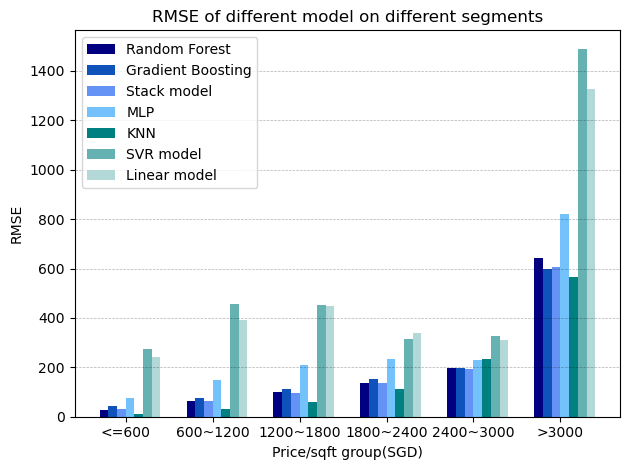

In [52]:
length = 6
x_labels = ['<=600', '600~1200','1200~1800', '1800~2400', '2400~3000', '>3000']

# Set plot parameters
fig, ax = plt.subplots()
width = 0.1 # width of bar
x = np.arange(length)

ax.bar(x, random_forest_mses, width, color='#000080', label='Random Forest')
ax.bar(x + width, gradient_boosting_mses, width, color='#0F52BA', label='Gradient Boosting')
ax.bar(x + (2 * width), stack_mses, width, color='#6593F5', label='Stack model')
ax.bar(x + (3 * width), mlp_mses, width, color='#73C2FB', label='MLP')
ax.bar(x + (4 * width), knn_mses, width, color='#008080', label='KNN')
ax.bar(x + (5 * width), svr_mses, width, color='#66b2b2', label='SVR model')
ax.bar(x + (6 * width), linear_mses, width, color='#b2d8d8', label='Linear model')

ax.set_ylabel('RMSE')

ax.set_xticks(x + width * 5 /2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Price/sqft group(SGD)')
ax.set_title('RMSE of different model on different segments')
ax.legend()
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()